# Pass clustering to see how teams penetrate into final third - Vse ekipe

In [1]:
import duckdb

import mplsoccer
from mplsoccer import Pitch, VerticalPitch

import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np

## Nalaganje in predprocesiranje podatkov

In [2]:
df_stories = duckdb.sql(f"""
    SELECT * FROM 'data/stories.parquet'
    WHERE type = 'pass'
""").df()

df_stories.head(3)

,player_position,throw_in,start_x,penalty_conceded_goal,penalty_foul,lateral_pass,own_goal,linkup_play,type,red_card,...,shot_goal_zone,conceded_goal,is_pass,possession_attack,pass_blocked,opportunity,possession_id,shot_id,possession_set_piece_attack,__index_level_0__
0,AMF,False,49,False,False,False,False,False,pass,False,...,None,False,True,True,False,False,1296149340,0,False,0
1,CF,False,27,False,False,False,False,False,pass,False,...,None,False,True,True,False,False,1296149340,0,False,1
2,RCB,False,57,False,False,False,False,False,pass,False,...,None,False,True,True,False,False,1296149340,0,False,3


In [3]:
df_stories.shape

(968435, 138)

**Podaje v zandjo tretino lahko filtriram z atributom pass_to_final_third**

In [3]:
df_stories_filtered = df_stories[df_stories['pass_to_final_third']]
df_stories_filtered.shape

(112931, 138)

**Znebiti se moram vseh podaj iz prekinitev in podaj golmanov z roko**

In [4]:
# List of columns to check
columns_to_check = [
    'possession_free_kick', 'free_kick', 'free_kick_cross', 
    'possession_free_kick_cross', 'possession_direct_free_kick', 
    'possession_corner', 'corner', 'possession_set_piece_attack',
    'hand_pass'
]

# Filter out rows where any of the specified columns are True
df_stories_brez_prekinitev = df_stories_filtered[~df_stories_filtered[columns_to_check].any(axis=1)]

# Display the first few rows to verify
df_stories_brez_prekinitev.shape

(89765, 138)

**Upošteval bom uspešne in neuspešne podaje**

In [6]:
df_stories_brez_prekinitev.value_counts('successful')

successful
True     63520
False    26245
Name: count, dtype: int64

In [7]:
df_stories_brez_prekinitev.value_counts('head_pass')

head_pass
False    86580
True      3185
Name: count, dtype: int64

In [8]:
df_stories_brez_prekinitev.value_counts('long_pass')

long_pass
False    58329
True     31436
Name: count, dtype: int64

**Spremenljivke, ki me zanimajo so:**
* lateral_pass
* forward_pass
* start_x
* start_y
* end_x
* end_y
* pass_length

**Pass height in pressure ne bo vplival na gručenje. Pravtako ne head_pass. Lateral in forward info bo zajet s kotom(angle).**

In [5]:
# List of columns to keep
columns_to_keep = [
    'start_x', 
    'start_y', 
    'end_x', 
    'end_y', 
    'pass_length',
    'successful'
]

# Select only the desired columns
df_done = df_stories_brez_prekinitev[columns_to_keep]

# Display the first few rows to verify
df_done.head()

,start_x,start_y,end_x,end_y,pass_length,successful
2,57,80,67,92,13,True
27,64,82,74,74,12,True
34,59,71,68,88,15,True
38,61,64,67,92,20,True
48,56,74,67,75,12,True


### Skaliranje x in y koordinat, da se ujema s standardnim igriščem 105x68

In [6]:
# Create a copy and scale the coordinates to real pitch dimensions (105x68 meters)
df_done_copy = df_done.copy()
df_done_copy["start_x"] *= 105 / 100
df_done_copy["start_y"] *= 68 / 100
df_done_copy["end_x"] *= 105 / 100
df_done_copy["end_y"] *= 68 / 100

df_done_copy.head(3)

,start_x,start_y,end_x,end_y,pass_length,successful
2,59.85,54.40,70.35,62.56,13,True
27,67.20,55.76,77.70,50.32,12,True
34,61.95,48.28,71.40,59.84,15,True


**Zaradi skaliranja koordinat se posledično spremeni tudi pass length - ponovni izračun z evklidsko razdaljo.**

In [7]:
# Recalculate pass_length using scaled coordinates
df_done_copy["pass_length"] = np.sqrt(
    (df_done_copy["end_x"] - df_done_copy["start_x"])**2 +
    (df_done_copy["end_y"] - df_done_copy["start_y"])**2
)

df_done_copy.head(3)

,start_x,start_y,end_x,end_y,pass_length,successful
2,59.85,54.40,70.35,62.56,13.297955,True
27,67.20,55.76,77.70,50.32,11.825549,True
34,61.95,48.28,71.40,59.84,14.931045,True


**Izračun kota podaje**

In [8]:
df_done_copy["angle"] = np.arctan2(df_done_copy["end_y"] - df_done_copy["start_y"], df_done_copy["end_x"] - df_done_copy["start_x"])
df_done_copy.head(3)

,start_x,start_y,end_x,end_y,pass_length,successful,angle
2,59.85,54.40,70.35,62.56,13.297955,True,0.660647
27,67.20,55.76,77.70,50.32,11.825549,True,-0.478019
34,61.95,48.28,71.40,59.84,14.931045,True,0.885491


**Hitra vizualizacija**

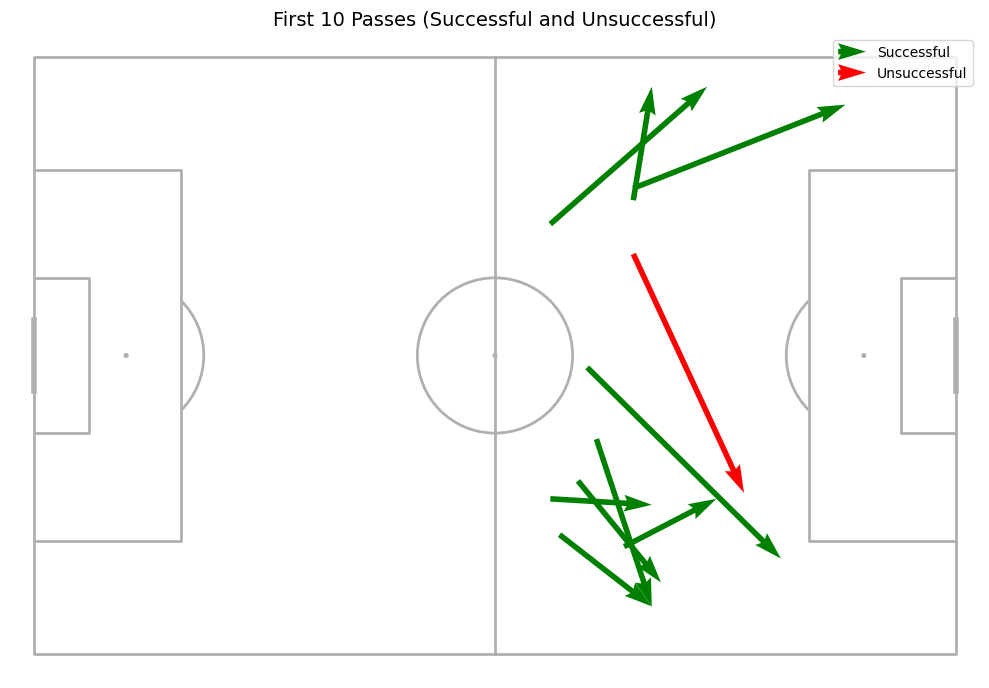

In [14]:
df_first_10_passes = df_stories_filtered.head(10)

# Create the pitch
pitch = Pitch(pitch_type='wyscout')
fig, ax = pitch.draw(figsize=(10, 7))

# Plot successful passes (green)
pitch.arrows(
    df_first_10_passes[df_first_10_passes['successful']]['start_x'],
    df_first_10_passes[df_first_10_passes['successful']]['start_y'],
    df_first_10_passes[df_first_10_passes['successful']]['end_x'],
    df_first_10_passes[df_first_10_passes['successful']]['end_y'],
    ax=ax, color='green', label='Successful'
)

# Plot unsuccessful passes (red)
pitch.arrows(
    df_first_10_passes[~df_first_10_passes['successful']]['start_x'],
    df_first_10_passes[~df_first_10_passes['successful']]['start_y'],
    df_first_10_passes[~df_first_10_passes['successful']]['end_x'],
    df_first_10_passes[~df_first_10_passes['successful']]['end_y'],
    ax=ax, color='red', label='Unsuccessful'
)

# Add legend and title
plt.legend()
plt.title('First 10 Passes (Successful and Unsuccessful)', fontsize=14)
plt.show()

In [15]:
df_done_copy.dtypes

start_x        float64
start_y        float64
end_x          float64
end_y          float64
pass_length    float64
successful        bool
angle          float64
dtype: object

## Gručenje

### Določanje optimalnega števila gruč

**Dataframe je prevelik za obdelavo, zato ga bom vzorčil na 50%.**

In [9]:
# Randomly sample 75% of the DataFrame
df_smaller = df_done_copy.sample(frac=0.50, random_state=123)

# Optionally, reset the index if needed
df_smaller.reset_index(drop=True, inplace=True)

print(f"Original size: {len(df_done_copy)}, Reduced size: {len(df_smaller)}")

Original size: 89765, Reduced size: 44882


In [10]:
import pyarrow
import fastparquet
# Save the reduced DataFrame as Parquet
df_smaller.to_parquet('data/reduced_dataset.parquet', index=False)

print("DataFrame saved successfully!")

DataFrame saved successfully!


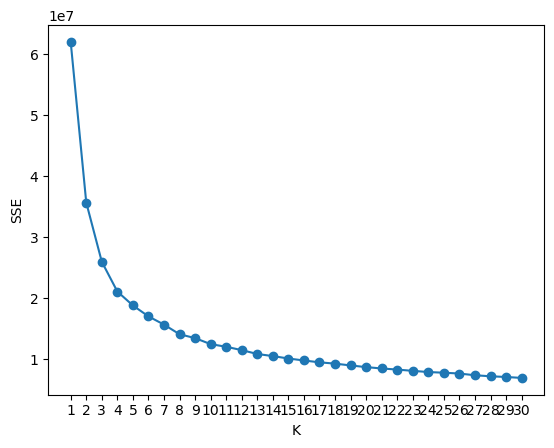

MemoryError: Unable to allocate 15.0 GiB for an array with shape (44882, 44882) and data type float64

In [11]:
from sklearn.cluster import KMeans

K = np.linspace(1, 30, 30)
X = df_smaller[["start_x", "start_y", "end_x", "end_y", "angle", "pass_length"]].values
elbow = {"sse": [], "k": [], "sil": []}
for k in K:
    cluster = KMeans(n_clusters = int(k), random_state = 2147)
    labels = cluster.fit_predict(X)
    elbow["sse"].append(cluster.inertia_)
    elbow["k"].append(k)

plt.scatter(elbow["k"], elbow["sse"])
plt.plot(elbow["k"], elbow["sse"])
plt.xticks(np.linspace(1, 30, 30))
plt.xlabel("K")
plt.ylabel("SSE")
plt.show()
from sklearn.metrics import pairwise_distances
def compute_inertia(a, X):
    W = [np.mean(pairwise_distances(X[a == c, :])) for c in np.unique(a)]
    return np.mean(W)

def compute_gap(clustering, data, k_max, n_references=5):
    if len(data.shape) == 1:
        data = data.reshape(-1, 1)
    reference = np.random.rand(*data.shape)
    reference_inertia = []
    for k in range(1, k_max+1):
        local_inertia = []
        for _ in range(n_references):
            clustering.n_clusters = k
            assignments = clustering.fit_predict(reference)
            local_inertia.append(compute_inertia(assignments, reference))
        reference_inertia.append(np.mean(local_inertia))

    ondata_inertia = []
    for k in range(1, k_max+1):
        clustering.n_clusters = k
        assignments = clustering.fit_predict(data)
        ondata_inertia.append(compute_inertia(assignments, data))

    gap = np.log(reference_inertia)-np.log(ondata_inertia)
    return gap, np.log(reference_inertia), np.log(ondata_inertia)

k_max = 30
gap, reference_inertia, ondata_inertia = compute_gap(KMeans(random_state = 2147), X, k_max)

plt.plot(range(1, k_max+1), gap, '-o')
plt.ylabel('gap')
plt.xlabel('k')

**Dataframe je bil še vedno prevelik za zgornjo funkcijo zato bom uporabil MiniBatchKmeans in funkcijo, ki uporablja centre gruč namesto pairwise distances. S tem bom dosegel:**
* procesiranje v manjših kosih za manjši memory usage
* izogibanje kreaciji large distance matrix

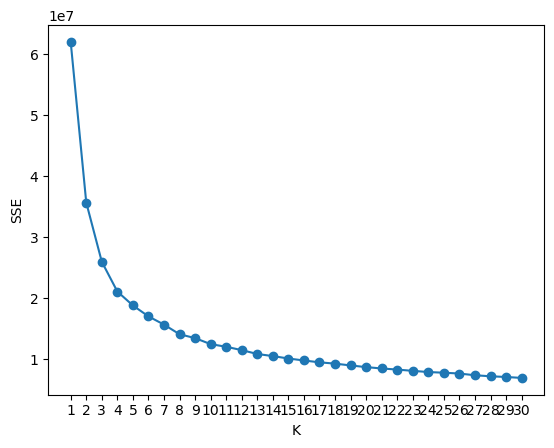

Text(0.5, 0, 'k')

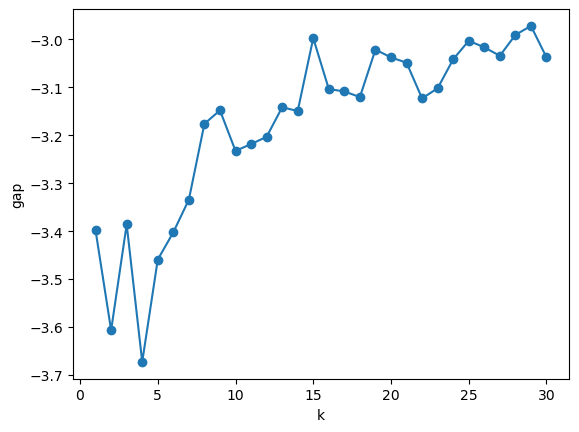

In [12]:
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import pairwise_distances_argmin_min

K = np.linspace(1, 30, 30)
X = df_smaller[["start_x", "start_y", "end_x", "end_y", "angle", "pass_length"]].values
elbow = {"sse": [], "k": [], "sil": []}
for k in K:
    cluster = KMeans(n_clusters = int(k), random_state = 2147)
    labels = cluster.fit_predict(X)
    elbow["sse"].append(cluster.inertia_)
    elbow["k"].append(k)

plt.scatter(elbow["k"], elbow["sse"])
plt.plot(elbow["k"], elbow["sse"])
plt.xticks(np.linspace(1, 30, 30))
plt.xlabel("K")
plt.ylabel("SSE")
plt.show()
from sklearn.metrics import pairwise_distances
def compute_inertia(a, X, centers):
    _, distances = pairwise_distances_argmin_min(centers, X)
    return np.mean(distances)

def compute_gap(clustering, data, k_max, n_references=5):
    reference = np.random.rand(*data.shape)
    reference_inertia = []
    for k in range(1, k_max + 1):
        local_inertia = []
        for _ in range(n_references):
            clustering.n_clusters = k
            clustering.fit(reference)
            centers = clustering.cluster_centers_
            local_inertia.append(compute_inertia(clustering.labels_, reference, centers))
        reference_inertia.append(np.mean(local_inertia))

    ondata_inertia = []
    for k in range(1, k_max + 1):
        clustering.n_clusters = k
        clustering.fit(data)
        centers = clustering.cluster_centers_
        ondata_inertia.append(compute_inertia(clustering.labels_, data, centers))

    gap = np.log(reference_inertia) - np.log(ondata_inertia)
    return gap, np.log(reference_inertia), np.log(ondata_inertia)

k_max = 30
gap, reference_inertia, ondata_inertia = compute_gap(MiniBatchKMeans(random_state = 2147), X, k_max)

plt.plot(range(1, k_max+1), gap, '-o')
plt.ylabel('gap')
plt.xlabel('k')

**Najbolj smiselna je delitev na 29 gruč na podlagi Gap Statistic Plot-a**

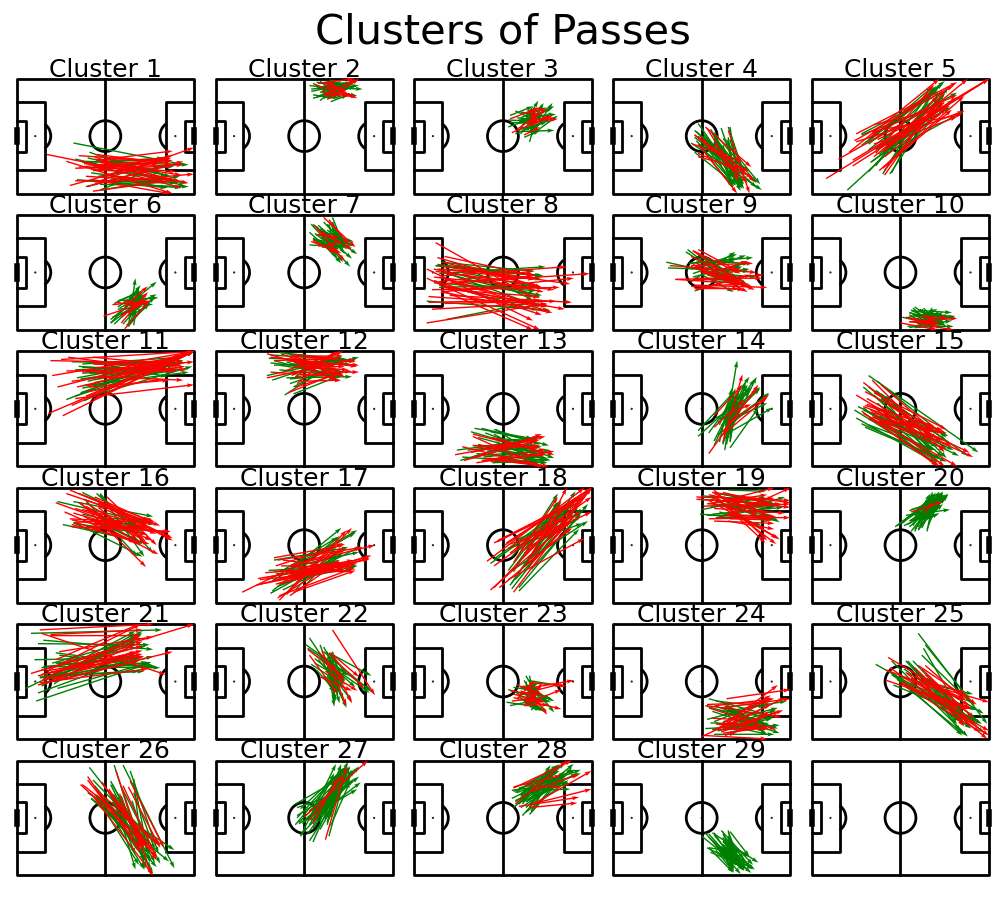

In [19]:
# Perform clustering
k = 29  # Number of clusters determined by Gap Statistic
cluster = KMeans(n_clusters=k, random_state=2147)
labels = cluster.fit_predict(df_done_copy[["start_x", "start_y", "end_x", "end_y", "angle"]].values)

# Add cluster labels to the dataframe
df_done_copy["label"] = labels

# Set up the pitch
pitch = Pitch(line_color='black', pitch_type="custom", pitch_length=105, pitch_width=68)
fig, axs = pitch.grid(
    ncols=5, nrows=6, grid_width=0.95, grid_height=0.9, title_height=0.05, axis=False,
    endnote_height=0.02, title_space=0.02, endnote_space=0.01
)

# Maximum number of passes to display per cluster
max_passes = 50

# Plot each cluster on a separate pitch
for clust, ax in zip(range(k), axs['pitch'].flat[:k]):
    # Add cluster label as title for each subplot
    ax.text(52.5, 74, f"Cluster {clust + 1}",
            ha='center', va='center', fontsize=18)
    
    # Filter passes belonging to the current cluster
    clustered = df_done_copy[df_done_copy["label"] == clust]

    # Limit the number of passes displayed
    if len(clustered) > max_passes:
        clustered = clustered.sample(n=max_passes, random_state=2147)
    
    # Separate successful and unsuccessful passes
    successful = clustered[clustered["successful"]]
    unsuccessful = clustered[~clustered["successful"]]
    
    # Plot successful passes (green)
    pitch.arrows(
        successful["start_x"], successful["start_y"],
        successful["end_x"], successful["end_y"],
        color="green", ax=ax, width=1, label="Successful"
    )
    
    # Plot unsuccessful passes (red)
    pitch.arrows(
        unsuccessful["start_x"], unsuccessful["start_y"],
        unsuccessful["end_x"], unsuccessful["end_y"],
        color="red", ax=ax, width=1, label="Unsuccessful"
    )

# Set the overall title
axs['title'].text(0.5, 0.5, 'Clusters of Passes', ha='center', va='center', fontsize=30)
plt.show()

**Prikazanih je zgolj 50 podaj za vsako gručo zaradi preglednosti**

In [20]:
df_done_copy.head(3)

,start_x,start_y,end_x,end_y,pass_length,successful,angle,label
2,59.85,54.40,70.35,62.56,13.297955,True,0.660647,19
27,67.20,55.76,77.70,50.32,11.825549,True,-0.478019,6
34,61.95,48.28,71.40,59.84,14.931045,True,0.885491,19


In [21]:
df_done_copy.to_csv("data/clustered_passes_1.csv", index=False)